# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 914 kB 39.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 67.1 MB/s eta 0:00:01


In [2]:
# TensorBoard
!pip install tensorboard

Defaulting to user installation because normal site-packages is not writeable


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# TensorBoard Import
from torch.utils.tensorboard import SummaryWriter

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##

# ToTensor converts PIL Image to tensor
# Normalize with Mean=0.1307, Std=0.3081 (MNIST Standards)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create training set and define training dataloader
## YOUR CODE HERE ##

# Download MNIST and apply transforms
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# DataLoader with batch size 64 and shuffle
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


# Create test set and define test dataloader
## YOUR CODE HERE ##

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# No shuffle needed for testing
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY** DONE

I use ToTensor() to convert PIL images to tensors (values 0-255 become 0-1).
Normalization with mean=0.1307 and std=0.3081 are MNIST standard values and help the 
network learn faster since input values are centered around 0. I think no additional transforms 
like rotation or augmentation are needed, because of 60,000 training images.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

2


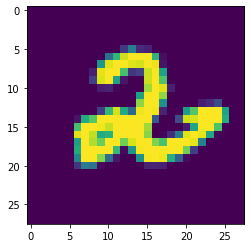

2


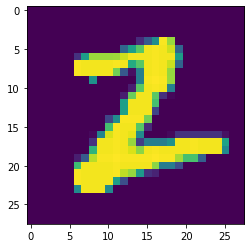

3


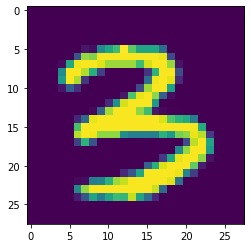

8


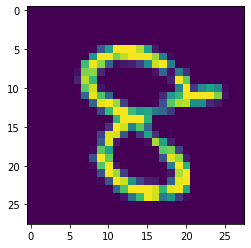

6


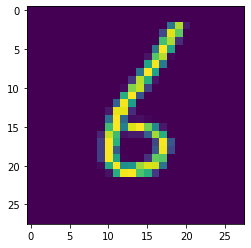

Training set size: 60000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


In [4]:
# Explore data
## YOUR CODE HERE ##

# Show 5 example images
show5(trainloader)

# Show dimensions
print(f'Training set size: {len(trainset)}')
print(f'Test set size: {len(testset)}')
print(f'Image shape: {trainset[0][0].shape}')  # (1, 28, 28) - 1 channel, 28x28 pixels
print(f'Number of classes: {len(trainset.classes)}')

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
## YOUR CODE HERE ##

# CNN architecture with 2 convolutional layers
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14x14 -> 14x14
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Halves the size
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After 2x pooling: 28->14->7
        self.fc2 = nn.Linear(128, 10)  # 10 classes (digits 0-9)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14
        
        # Conv2 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7
        
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##

# Loss and optimizer
# CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Instantiate model
model = MNISTNet()

# Adam optimizer with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'Training on: {device}')

# Create TensorBoard writer
writer = SummaryWriter('runs/mnist_experiment')
print('TensorBoard logs saved to runs/mnist_experiment')

Training on: cuda
TensorBoard logs saved to runs/mnist_experiment


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [3]:
# Start TensorBoard in notebook
%load_ext tensorboard
%tensorboard --logdir runs

TensorBoard started at http://localhost:6006


In [2]:
## YOUR CODE HERE ##

# Training loop with TensorBoard
epochs = 10
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Log loss to TensorBoard
        global_step = epoch * len(trainloader) + i
        writer.add_scalar('Training/Loss_Batch', loss.item(), global_step)
        
        if i % 250 == 249:
            avg_loss = running_loss / 250
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {avg_loss:.3f}')
            running_loss = 0.0
    
    # Loss per epoch
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    writer.add_scalar('Training/Loss_Epoch', epoch_loss, epoch)
    
    # Validation accuracy per epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    writer.add_scalar('Validation/Accuracy', val_accuracy, epoch)
    print(f'Epoch {epoch+1}/{epochs}, Val Accuracy: {val_accuracy:.2f}%')
    model.train()

print('Training finished')

NameError: name 'model' is not defined

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
## YOUR CODE HERE ##

# Plot loss
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##

# Test model
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

# Log to TensorBoard
writer.add_scalar('Test/Final_Accuracy', accuracy, 0)
writer.close()

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##

# Save model
torch.save(model.state_dict(), 'mnist_cnn_model.pth')
print('Model saved as mnist_cnn_model.pth')

# Load later with:
# model = MNISTNet()
# model.load_state_dict(torch.load('mnist_cnn_model.pth'))